<a href="https://colab.research.google.com/github/ShariqAhmed007/Housing-Price-Index-using-VAR-/blob/main/Time_series_factor_analysis_of_Housing_Prices_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from datetime import datetime

In [ ]:
pip install pmdarima

In [ ]:
import pmdarima as pm

In [ ]:
from google.colab import files

# First dataset

In [ ]:
cleaned = pd.read_csv("/content/Cleaned.csv", parse_dates=True,  dayfirst = True)

In [ ]:
cleaned.head()

,DATE,CSUSHPISA,CONSSENT,CPI,POP,LABPARTRATE,LABCONS,WORKPOP,UNRATE,RECPROB,S&P500,PPILUMBWOOD,PPIIRONSTEEL,PCDISPINC,PERMIT,UNDCONSPI
0,01-01-1990,76.897,93.0,127.5,248743,66.8,5422,159257,5.4,0.42,329.08,129.0,116.7,27341,989,57.2
1,01-02-1990,77.053,89.5,128.0,248920,66.7,5416,159383,5.3,0.30,331.89,129.7,116.2,27379,963,57.4
2,01-03-1990,77.200,91.3,128.6,249146,66.7,5392,159425,5.2,0.46,339.94,130.5,116.5,27361,912,57.5
3,01-04-1990,77.278,93.9,128.9,249436,66.6,5355,159536,5.4,1.50,330.80,132.4,117.1,27505,818,57.6
4,01-05-1990,77.297,90.6,129.1,249707,66.6,5321,159598,5.4,1.92,361.23,132.0,117.9,27442,793,57.6


In [ ]:
cleaned = cleaned.rename(columns={'CSUSHPISA':'HPI'})

In [ ]:
cleaned.columns

Index(['DATE', 'HPI', 'CONSSENT', 'CPI', 'POP', 'LABPARTRATE', 'LABCONS',
       'WORKPOP', 'UNRATE', 'RECPROB', 'S&P500', 'PPILUMBWOOD', 'PPIIRONSTEEL',
       'PCDISPINC', 'PERMIT', 'UNDCONSPI'],
      dtype='object')

**The following are the features collected for analysis:**
* DATE - Monthly dates
* HPI - Case-Shiller Housing Price Index (Target variable)
* CONSSENT - Consumer Sentiment
* CPI - Consumer Price Index
* POP - Population (Thousands)
* LABPARTRATE - Labour Participation Rate (Percent)
* LABCONS - Labour involved in Construction (Thousands)
* WORKPOP - Working population
* UNRATE - Unemployment rate (Percent)
* RECPROB - Recent probability
* S&P500 - S&P500
* PPILUMBWOOD - Producers Price Index Lumber & Wood     
* PPIIRONSTEEL - Producers Price Index Iron & Steel
* PCDISPINC - Per Capita Disposable Income
* PERMIT - Permits granted for new housing (Thousands)
* UNDCONSPI - Under Construction Housing Price Index

In [ ]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          372 non-null    object 
 1   HPI           372 non-null    float64
 2   CONSSENT      372 non-null    float64
 3   CPI           372 non-null    float64
 4   POP           372 non-null    int64  
 5   LABPARTRATE   372 non-null    float64
 6   LABCONS       372 non-null    int64  
 7   WORKPOP       372 non-null    int64  
 8   UNRATE        372 non-null    float64
 9   RECPROB       372 non-null    float64
 10  S&P500        372 non-null    float64
 11  PPILUMBWOOD   372 non-null    float64
 12  PPIIRONSTEEL  372 non-null    float64
 13  PCDISPINC     372 non-null    int64  
 14  PERMIT        372 non-null    int64  
 15  UNDCONSPI     372 non-null    float64
dtypes: float64(10), int64(5), object(1)
memory usage: 46.6+ KB


In [ ]:
cleaned['DATE'] = pd.to_datetime(cleaned['DATE'], dayfirst= True)

In [ ]:
cleaned['DATE'] = cleaned['DATE'].dt.strftime('%m-%Y')

In [ ]:
cleaned.DATE

0      01-1990
1      02-1990
2      03-1990
3      04-1990
4      05-1990
        ...   
367    08-2020
368    09-2020
369    10-2020
370    11-2020
371    12-2020
Name: DATE, Length: 372, dtype: object

In [ ]:
cleaned = cleaned.set_index(cleaned.DATE) 

In [ ]:
cleaned = cleaned.drop(cleaned[['DATE']], axis = 1)

In [ ]:
cleaned.head()

,HPI,CONSSENT,CPI,POP,LABPARTRATE,LABCONS,WORKPOP,UNRATE,RECPROB,S&P500,PPILUMBWOOD,PPIIRONSTEEL,PCDISPINC,PERMIT,UNDCONSPI
DATE,,,,,,,,,,,,,,,
01-1990,76.897,93.0,127.5,248743,66.8,5422,159257,5.4,0.42,329.08,129.0,116.7,27341,989,57.2
02-1990,77.053,89.5,128.0,248920,66.7,5416,159383,5.3,0.30,331.89,129.7,116.2,27379,963,57.4
03-1990,77.200,91.3,128.6,249146,66.7,5392,159425,5.2,0.46,339.94,130.5,116.5,27361,912,57.5
04-1990,77.278,93.9,128.9,249436,66.6,5355,159536,5.4,1.50,330.80,132.4,117.1,27505,818,57.6
05-1990,77.297,90.6,129.1,249707,66.6,5321,159598,5.4,1.92,361.23,132.0,117.9,27442,793,57.6


In [ ]:
cleaned.describe()

,HPI,CONSSENT,CPI,POP,LABPARTRATE,LABCONS,WORKPOP,UNRATE,RECPROB,S&P500,PPILUMBWOOD,PPIIRONSTEEL,PCDISPINC,PERMIT,UNDCONSPI
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,136.026142,87.360215,195.651024,294284.067204,65.281183,6278.228495,187225.524194,5.914785,7.391237,1333.436075,192.173925,169.372312,35924.440860,954.741935,92.071237
std,45.111451,12.291420,38.953166,24259.571706,1.697587,901.059986,15928.820281,1.738426,21.903615,750.663776,29.062198,51.067050,5611.481287,340.255736,23.613118
min,75.566000,55.300000,127.500000,248743.000000,60.200000,4570.000000,159257.000000,3.500000,0.020000,304.000000,126.800000,107.100000,26980.000000,337.000000,57.200000
25%,86.076000,78.300000,161.425000,273917.500000,63.400000,5536.250000,171637.250000,4.600000,0.140000,846.422500,177.200000,118.550000,30547.250000,698.500000,71.275000
50%,141.588000,89.650000,194.300000,295950.500000,66.100000,6435.000000,190969.000000,5.500000,0.260000,1219.610000,189.350000,172.900000,36600.000000,924.500000,96.400000
75%,173.314250,95.900000,231.990250,315721.750000,66.600000,6959.000000,202077.000000,6.825000,0.905000,1576.285000,213.125000,213.750000,39463.750000,1189.500000,107.350000
max,235.560000,112.000000,261.560000,330924.000000,67.300000,7726.000000,207388.000000,14.800000,100.000000,3756.070000,285.600000,294.400000,52070.000000,1798.000000,143.200000


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

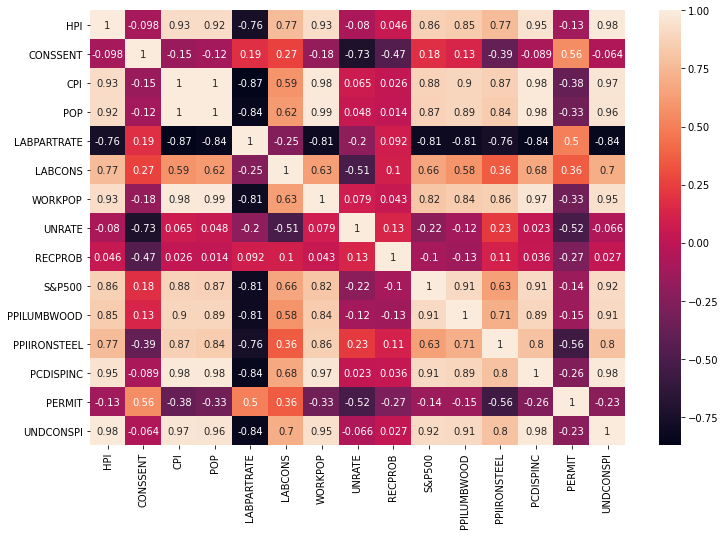

In [ ]:
# Plotting correlation matrix to see patterns
ax = sns.heatmap(cleaned.corr(), annot=True)

**The above heatmap shows us high correlation values, but we shouldn't take these values seriously, because we are here dealing with time series data.**

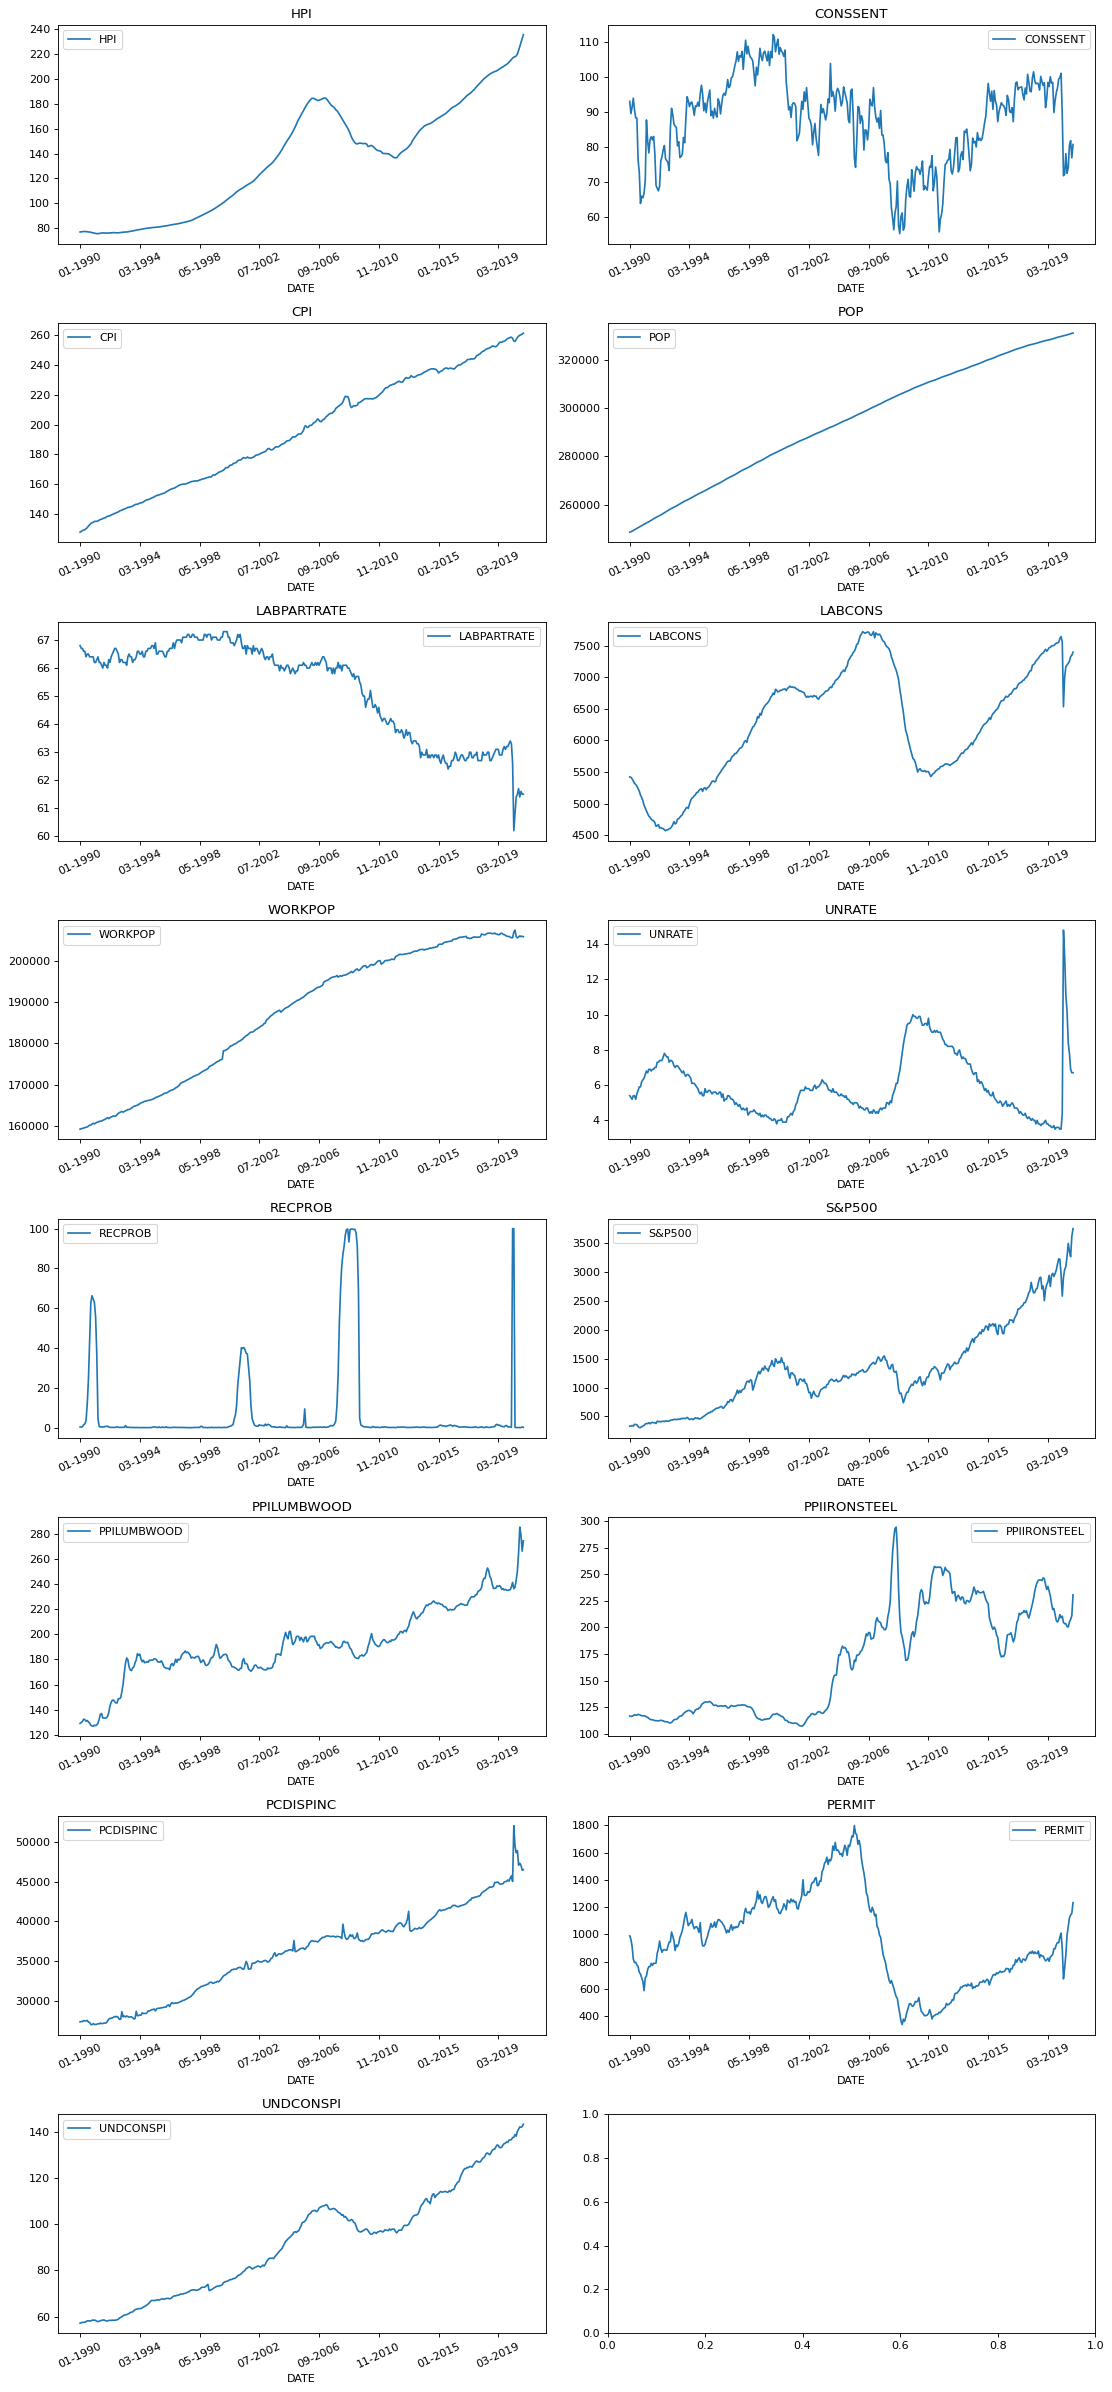

In [ ]:
def Visualize(data):
    features= list(cleaned.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(cleaned)

It can be observed from the graphs that most of our features are not stationary time series (the data doesnt have a constant mean and variation)
For analysis of time series data stationarity is necessary and we will check it statistically through **Augmented Dickey Fuller Test**

In [ ]:
# Augmented Dicky Fuller test to test for stationarity of out time series data
for i in range(0,15):
  results = adfuller(cleaned[cleaned.columns[i]])
  if results[1] > 0.05 :
    print('{} - Not stationary'.format(cleaned.columns[i]))
  else:
    print('{} - Stationary'.format(cleaned.columns[i]))

HPI - Not stationary
CONSSENT - Not stationary
CPI - Not stationary
POP - Not stationary
LABPARTRATE - Not stationary
LABCONS - Not stationary
WORKPOP - Not stationary
UNRATE - Stationary
RECPROB - Stationary
S&P500 - Not stationary
PPILUMBWOOD - Not stationary
PPIIRONSTEEL - Not stationary
PCDISPINC - Not stationary
PERMIT - Not stationary
UNDCONSPI - Not stationary


All features are non-stationary except UNRATE and RECPROB.
We will remove this non stationarity with the help of method of differencing the series

In [ ]:
# Finding the optimal differencing for each feature to make it stationary 
def Optimal_Difference(data):
  ns = list(data.columns)
  ns.remove('UNRATE')
  ns.remove('RECPROB')
  ns_size = len(ns)

  d_val_list = []
  for i in range(ns_size):      
        key = ns[i]
        d_val = pm.arima.ndiffs(data[key], test='kpss', max_d=4)
        d_val_list.append(d_val)
  
  return d_val_list, ns

In [ ]:
d_val_list = Optimal_Difference(cleaned)[0]
ns = Optimal_Difference(cleaned)[1]

In [ ]:
print(d_val_list)
print(ns)

[2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2]
['HPI', 'CONSSENT', 'CPI', 'POP', 'LABPARTRATE', 'LABCONS', 'WORKPOP', 'S&P500', 'PPILUMBWOOD', 'PPIIRONSTEEL', 'PCDISPINC', 'PERMIT', 'UNDCONSPI']


In [ ]:
cleaned_lag = cleaned

In [ ]:
#Differencing of 2
cleaned_lag['HPI_lag'] = cleaned_lag['HPI'].rolling(window=3).apply(lambda x : x.iloc[2] - (2*x.iloc[1]) + x.iloc[0])
#Differencing of 1
cleaned_lag['CONSSENT_lag'] = cleaned_lag['CONSSENT'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
cleaned_lag['CPI_lag'] = cleaned_lag['CPI'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
#2
cleaned_lag['POP_lag'] = cleaned_lag['POP'].rolling(window=3).apply(lambda x : x.iloc[2] - (2*x.iloc[1]) + x.iloc[0])
#1
cleaned_lag['LABPARTRATE_lag'] = cleaned_lag['LABPARTRATE'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
cleaned_lag['LABCONS_lag'] = cleaned_lag['LABCONS'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
#2
cleaned_lag['WORKPOP_lag'] = cleaned_lag['WORKPOP'].rolling(window=3).apply(lambda x : x.iloc[2] - (2*x.iloc[1]) + x.iloc[0])
cleaned_lag['S&P500_lag'] = cleaned_lag['S&P500'].rolling(window=3).apply(lambda x : x.iloc[2] - (2*x.iloc[1]) + x.iloc[0])
#1
cleaned_lag['PPILUMBWOOD_lag'] = cleaned_lag['PPILUMBWOOD'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
cleaned_lag['PPIIRONSTEEL_lag'] = cleaned_lag['PPIIRONSTEEL'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
cleaned_lag['PCDISPINC_lag'] = cleaned_lag['PCDISPINC'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
cleaned_lag['PERMIT_lag'] = cleaned_lag['PERMIT'].rolling(window=2).apply(lambda x : x.iloc[1] - x.iloc[0])
#2
cleaned_lag['UNDCONSPI_lag'] = cleaned_lag['UNDCONSPI'].rolling(window=3).apply(lambda x : x.iloc[2] - (2*x.iloc[1]) + x.iloc[0])

In [ ]:
# the lag features are the stationary versions of our features 
cleaned_lag.head()

,HPI,CONSSENT,CPI,POP,LABPARTRATE,LABCONS,WORKPOP,UNRATE,RECPROB,S&P500,PPILUMBWOOD,PPIIRONSTEEL,PCDISPINC,PERMIT,UNDCONSPI,HPI_lag,CONSSENT_lag,CPI_lag,POP_lag,LABPARTRATE_lag,LABCONS_lag,WORKPOP_lag,S&P500_lag,PPILUMBWOOD_lag,PPIIRONSTEEL_lag,PCDISPINC_lag,PERMIT_lag,UNDCONSPI_lag
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01-1990,76.897,93.0,127.5,248743,66.8,5422,159257,5.4,0.42,329.08,129.0,116.7,27341,989,57.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02-1990,77.053,89.5,128.0,248920,66.7,5416,159383,5.3,0.30,331.89,129.7,116.2,27379,963,57.4,NaN,-3.5,0.5,NaN,-0.1,-6.0,NaN,NaN,0.7,-0.5,38.0,-26.0,NaN
03-1990,77.200,91.3,128.6,249146,66.7,5392,159425,5.2,0.46,339.94,130.5,116.5,27361,912,57.5,-0.009,1.8,0.6,49.0,0.0,-24.0,-84.0,5.24,0.8,0.3,-18.0,-51.0,-0.1
04-1990,77.278,93.9,128.9,249436,66.6,5355,159536,5.4,1.50,330.80,132.4,117.1,27505,818,57.6,-0.069,2.6,0.3,64.0,-0.1,-37.0,69.0,-17.19,1.9,0.6,144.0,-94.0,0.0
05-1990,77.297,90.6,129.1,249707,66.6,5321,159598,5.4,1.92,361.23,132.0,117.9,27442,793,57.6,-0.059,-3.3,0.2,-19.0,0.0,-34.0,-49.0,39.57,-0.4,0.8,-63.0,-25.0,-0.1


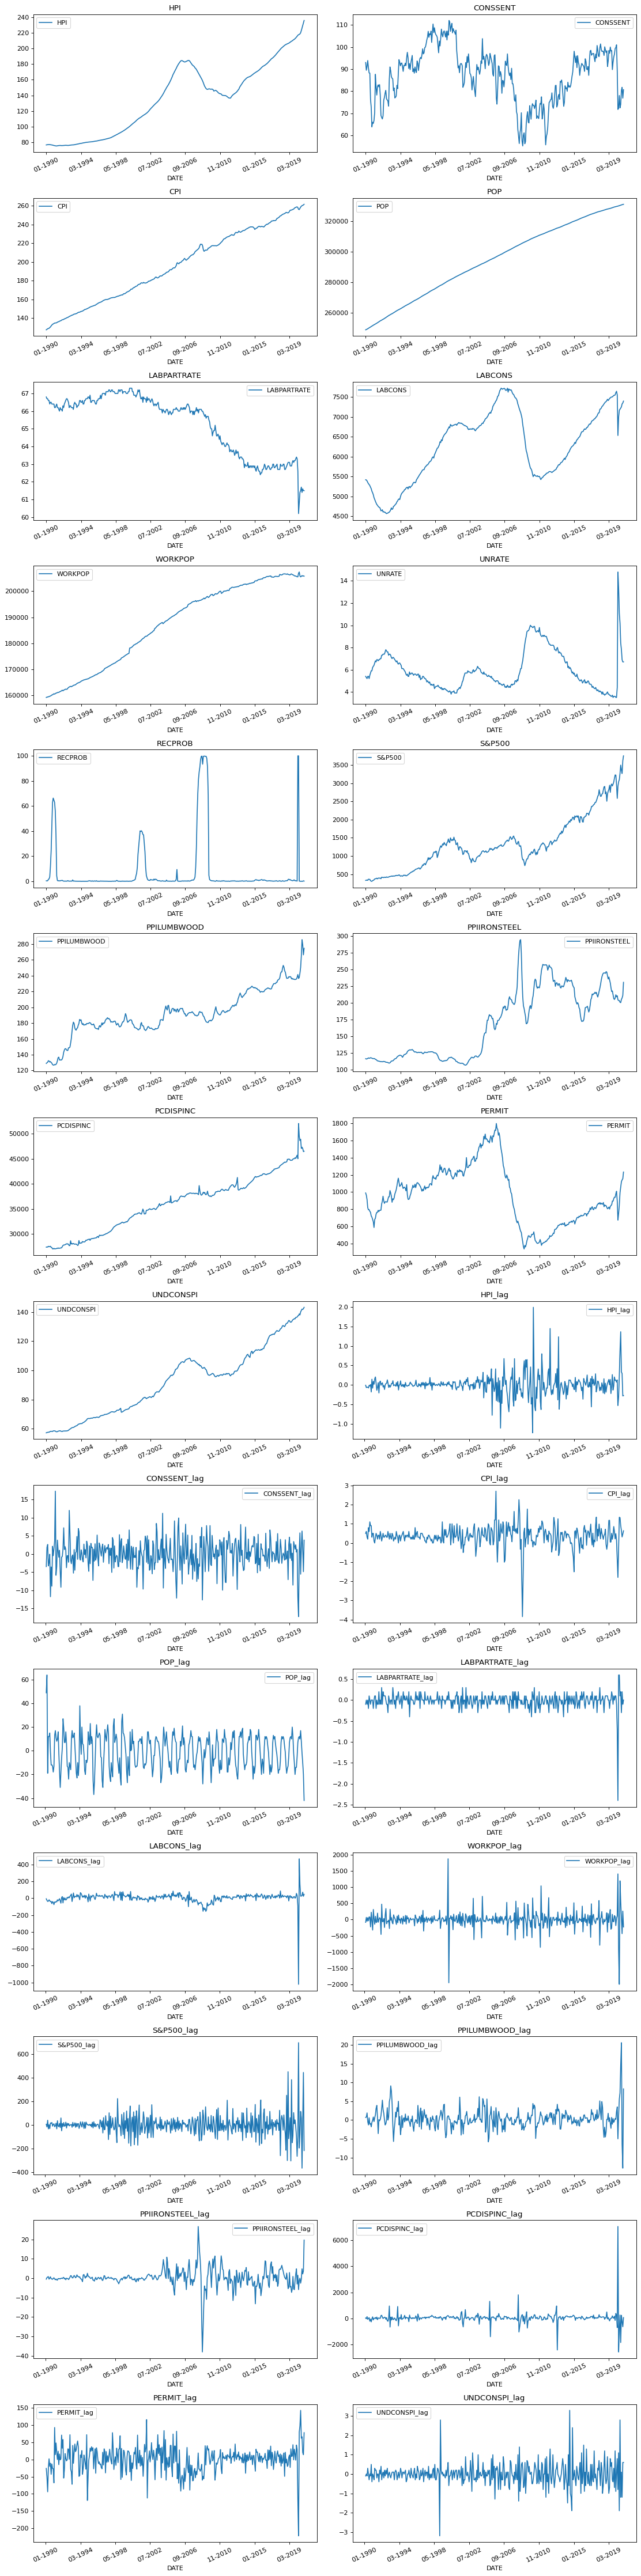

In [ ]:
# Visualising to see features post-differencing 
Visualize(cleaned_lag)

In [ ]:
# Augmented Dicky Fuller test again
# Null H - Series not stationary
# Alt H - Series stationary
for i in range(0,len(cleaned_lag.columns)):
  results = adfuller(cleaned_lag[cleaned_lag.columns[i]][5:])
  if results[1] > 0.05 :
    print('{} - Not stationary'.format(cleaned_lag.columns[i]))
  else:
    print('{} - Stationary'.format(cleaned_lag.columns[i]))

HPI - Not stationary
CONSSENT - Not stationary
CPI - Not stationary
POP - Not stationary
LABPARTRATE - Not stationary
LABCONS - Stationary
WORKPOP - Not stationary
UNRATE - Stationary
RECPROB - Stationary
S&P500 - Not stationary
PPILUMBWOOD - Not stationary
PPIIRONSTEEL - Not stationary
PCDISPINC - Not stationary
PERMIT - Not stationary
UNDCONSPI - Not stationary
HPI_lag - Stationary
CONSSENT_lag - Stationary
CPI_lag - Stationary
POP_lag - Stationary
LABPARTRATE_lag - Stationary
LABCONS_lag - Stationary
WORKPOP_lag - Stationary
S&P500_lag - Stationary
PPILUMBWOOD_lag - Stationary
PPIIRONSTEEL_lag - Stationary
PCDISPINC_lag - Stationary
PERMIT_lag - Not stationary
UNDCONSPI_lag - Stationary


All the lag variables are now stationary except PERMIT

In [ ]:
# Trying differencing of 2
cleaned_lag['PERMIT_lag'] = cleaned_lag['PERMIT'].rolling(window=3).apply(lambda x : x.iloc[2] - (2*x.iloc[1]) + x.iloc[0])

In [ ]:
# Augmented Dicky Fuller test
# Null H - Series not stationary
# Alt H - Series stationary
# (t stat > 0.05 implies series is Not Stationary
adfuller(cleaned_lag[cleaned_lag.columns[len(cleaned_lag.columns)-2]][5:])[1] > 0.05

False

In [ ]:
l = list(cleaned.columns[15:len(cleaned.columns)])
cleaned_lag = cleaned_lag.loc['05-1999':,['UNRATE','RECPROB'] + l]
cleaned_lag.head()

,UNRATE,RECPROB,HPI_lag,CONSSENT_lag,CPI_lag,POP_lag,LABPARTRATE_lag,LABCONS_lag,WORKPOP_lag,S&P500_lag,PPILUMBWOOD_lag,PPIIRONSTEEL_lag,PCDISPINC_lag,PERMIT_lag,UNDCONSPI_lag
DATE,,,,,,,,,,,,,,,
05-1999,4.2,0.04,-0.008,2.2,0.1,15.0,0.0,36.0,63.0,-82.15,2.1,0.3,30.0,39.0,0.1
06-1999,4.3,0.14,0.070,0.5,0.0,14.0,0.0,31.0,29.0,104.21,4.1,0.7,81.0,-5.0,-0.1
07-1999,4.3,0.08,-0.013,-1.3,0.7,11.0,0.0,24.0,-64.0,-114.86,4.2,-0.4,32.0,-22.0,0.0
08-1999,4.2,0.08,0.011,-1.5,0.4,4.0,-0.1,15.0,-12.0,35.68,-2.4,0.6,106.0,-33.0,-0.1
09-1999,4.2,0.18,0.017,2.7,0.7,-3.0,0.0,27.0,-42.0,-29.39,-4.7,-0.1,-71.0,-12.0,-0.2


All of the variables are now stationary

In [ ]:
cleaned_lag.insert(0, 'HPI_lag', cleaned_lag.pop('HPI_lag'))
cleaned_lag.head()

,HPI_lag,UNRATE,RECPROB,CONSSENT_lag,CPI_lag,POP_lag,LABPARTRATE_lag,LABCONS_lag,WORKPOP_lag,S&P500_lag,PPILUMBWOOD_lag,PPIIRONSTEEL_lag,PCDISPINC_lag,PERMIT_lag,UNDCONSPI_lag
DATE,,,,,,,,,,,,,,,
05-1999,-0.008,4.2,0.04,2.2,0.1,15.0,0.0,36.0,63.0,-82.15,2.1,0.3,30.0,39.0,0.1
06-1999,0.070,4.3,0.14,0.5,0.0,14.0,0.0,31.0,29.0,104.21,4.1,0.7,81.0,-5.0,-0.1
07-1999,-0.013,4.3,0.08,-1.3,0.7,11.0,0.0,24.0,-64.0,-114.86,4.2,-0.4,32.0,-22.0,0.0
08-1999,0.011,4.2,0.08,-1.5,0.4,4.0,-0.1,15.0,-12.0,35.68,-2.4,0.6,106.0,-33.0,-0.1
09-1999,0.017,4.2,0.18,2.7,0.7,-3.0,0.0,27.0,-42.0,-29.39,-4.7,-0.1,-71.0,-12.0,-0.2


In [ ]:
# Granger causality test gives us an idea about which features have causal effect on the target variable
# Null H - X does not Granger causes Y
# Alt H - X Granger causes Y

maximum_lags = 6
y = 'HPI_lag'

In [ ]:
for i in range(len(cleaned_lag.columns)-1):
  results=grangercausalitytests(cleaned_lag[[y,cleaned_lag.columns[i+1]]], maximum_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(maximum_lags)]
  print('Column- {}: P_Values- {}'.format(cleaned_lag.columns[i+1],p_values))

Column- UNRATE: P_Values- [0.0452, 0.0167, 0.0135, 0.0149, 0.0002, 0.0003]
Column- RECPROB: P_Values- [0.6411, 0.3529, 0.0766, 0.004, 0.0037, 0.0048]
Column- CONSSENT_lag: P_Values- [0.1783, 0.0471, 0.0518, 0.0149, 0.0215, 0.0405]
Column- CPI_lag: P_Values- [0.1378, 0.0852, 0.0234, 0.0444, 0.0326, 0.011]
Column- POP_lag: P_Values- [0.9017, 0.6576, 0.2543, 0.0573, 0.1079, 0.1624]
Column- LABPARTRATE_lag: P_Values- [0.0351, 0.0674, 0.0954, 0.0027, 0.0015, 0.0003]
Column- LABCONS_lag: P_Values- [0.2994, 0.5632, 0.3511, 0.0032, 0.0012, 0.0012]
Column- WORKPOP_lag: P_Values- [0.1091, 0.1452, 0.3366, 0.4771, 0.3034, 0.2567]
Column- S&P500_lag: P_Values- [0.8245, 0.3979, 0.154, 0.0005, 0.0003, 0.0001]
Column- PPILUMBWOOD_lag: P_Values- [0.0379, 0.0883, 0.1171, 0.1056, 0.2202, 0.307]
Column- PPIIRONSTEEL_lag: P_Values- [0.2009, 0.2886, 0.0908, 0.0044, 0.0044, 0.0097]
Column- PCDISPINC_lag: P_Values- [0.4241, 0.0643, 0.0856, 0.0029, 0.0041, 0.0039]
Column- PERMIT_lag: P_Values- [0.0655, 0.0004,

UNRATE, RECPROB, CONSSENT, CPI, LABPARTRATE, PPIIRONSTEEL, PERMIT
will form our first model, as 4 out of 6 lags significantly granger cause HPI

In [ ]:
input = cleaned_lag[['HPI_lag', 'UNRATE', 'RECPROB', 'CONSSENT_lag', 'CPI_lag', 'LABPARTRATE_lag', 'PPIIRONSTEEL_lag', 'PERMIT_lag']]
input

,HPI_lag,UNRATE,RECPROB,CONSSENT_lag,CPI_lag,LABPARTRATE_lag,PPIIRONSTEEL_lag,PERMIT_lag
DATE,,,,,,,,
05-1999,-0.008,4.2,0.04,2.2,0.100,0.0,0.3,39.0
06-1999,0.070,4.3,0.14,0.5,0.000,0.0,0.7,-5.0
07-1999,-0.013,4.3,0.08,-1.3,0.700,0.0,-0.4,-22.0
08-1999,0.011,4.2,0.08,-1.5,0.400,-0.1,0.6,-33.0
09-1999,0.017,4.2,0.18,2.7,0.700,0.0,-0.1,-12.0
...,...,...,...,...,...,...,...,...
08-2020,1.366,8.4,0.10,1.6,0.907,0.2,-0.5,-81.0
09-2020,0.332,7.8,0.12,6.3,0.638,-0.3,4.8,4.0
10-2020,0.293,6.9,0.06,1.4,0.313,0.2,2.2,-46.0


In [ ]:
#Finding optimal value of lags to choose
model = VAR(input)
model.select_order(12).summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


,AIC,BIC,FPE,HQIC
0,15.30,15.41,4.417e+06,15.35
1,9.328,10.35,1.126e+04,9.739
2,8.399,10.33*,4448.,9.174*
3,8.096*,10.93,3299.*,9.236
4,8.153,11.89,3518.,9.658
5,8.311,12.96,4169.,10.18
6,8.381,13.93,4551.,10.62
7,8.469,14.93,5097.,11.07
8,8.416,15.78,4996.,11.38
9,8.332,16.61,4796.,11.66


In [ ]:
#We will select lag order of 3 for the first model
model = VAR(input)
results = model.fit(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


In [ ]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Sep, 2021
Time:                     12:19:31
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    10.6477
Nobs:                     257.000    HQIC:                   8.99652
Log likelihood:          -3730.66    FPE:                    2672.44
AIC:                      7.88581    Det(Omega_mle):         1271.69
--------------------------------------------------------------------
Results for equation HPI_lag
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.114687         0.076470           -1.500           0.134
L1.HPI_lag                 -0.068834         0.065350           -1.053           0.292
L1.UNRATE                   0.0045

In [ ]:
results_coeff=pd.DataFrame([results.params['HPI_lag'],results.pvalues['HPI_lag']]).T

In [ ]:
results_coeff

,HPI_lag,HPI_lag
const,-0.114687,0.133673
L1.HPI_lag,-0.068834,0.292199
L1.UNRATE,0.004596,0.933549
L1.RECPROB,-0.000547,0.834800
L1.CONSSENT_lag,0.006978,0.177596
L1.CPI_lag,0.026106,0.538860
L1.LABPARTRATE_lag,0.051966,0.719033
L1.PPIIRONSTEEL_lag,-0.009750,0.050847
L1.PERMIT_lag,0.001689,0.004417
L2.HPI_lag,0.007430,0.907306


In [ ]:
results_coeff.columns = ['coeff','pval']

In [ ]:
results_coeff.query('pval < 0.1')
np.where(results_coeff['pval'] < 0.1,1, 0)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1])

In [ ]:
results_coeff['significant']=np.where(results_coeff['pval'] < 0.1,1, 0)

In [ ]:
#we can see the significant features for our target variable
results_coeff

,coeff,pval,significant
const,-0.114687,0.133673,0
L1.HPI_lag,-0.068834,0.292199,0
L1.UNRATE,0.004596,0.933549,0
L1.RECPROB,-0.000547,0.834800,0
L1.CONSSENT_lag,0.006978,0.177596,0
L1.CPI_lag,0.026106,0.538860,0
L1.LABPARTRATE_lag,0.051966,0.719033,0
L1.PPIIRONSTEEL_lag,-0.009750,0.050847,1
L1.PERMIT_lag,0.001689,0.004417,1
L2.HPI_lag,0.007430,0.907306,0


The first model reflects that lag 1 of PPIIRONSTEEL, PERMIT,
 lag 2 of CONSSENT, PPIIRONSTEEL, PERMIT, HPI, lag 3 of HPI and PERMIT significantly affect our model.

All of the above except lag 1 of PPIIRONSTEEL and lag 3 of HPI have positive coefficients.

In [ ]:
input2 = cleaned_lag

In [ ]:
#For 2nd model we will use all of the features
model = VAR(input2)
model.select_order(12).summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


,AIC,BIC,FPE,HQIC
0,61.17,61.38,3.686e+26,61.26
1,52.68,56.08*,7.581e+22,54.05
2,51.14,57.73,1.651e+22,53.79*
3,50.46,60.23,8.761e+21,54.39
4,49.99,62.95,5.995e+21,55.21
5,49.98,66.13,6.922e+21,56.49
6,49.56,68.90,5.703e+21,57.34
7,49.59,72.11,8.279e+21,58.66
8,49.11,74.82,8.313e+21,59.46
9,48.52,77.42,9.019e+21,60.16


In [ ]:
#We will select lag order of 2 for second model
model2 = VAR(input2)
results2 = model2.fit(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


In [ ]:
results_coeff2=pd.DataFrame([results2.params['HPI_lag'],results2.pvalues['HPI_lag']]).T

In [ ]:
results_coeff2.columns = ['coeff','pval']

In [ ]:
results_coeff2.query('pval < 0.1')
np.where(results_coeff2['pval'] < 0.1,1, 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0])

In [ ]:
results_coeff2['significant']=np.where(results_coeff2['pval'] < 0.1,1, 0)

In [ ]:
results_coeff2

,coeff,pval,significant
const,-0.098067,0.229255,0
L1.HPI_lag,-0.094194,0.154879,0
L1.UNRATE,0.044110,0.587692,0
L1.RECPROB,0.001338,0.609502,0
L1.CONSSENT_lag,0.006130,0.255561,0
L1.CPI_lag,0.064743,0.120977,0
L1.POP_lag,-0.002205,0.359504,0
L1.LABPARTRATE_lag,0.232383,0.108874,0
L1.LABCONS_lag,0.000163,0.801089,0
L1.WORKPOP_lag,0.000176,0.015913,1


The second model reflects that lag 1 of WORKPOP, PPILUMBWOOD, PERMIT and lag 2 of CONSSENT, PCDISPINC and PERMIT significantly affect our model.

All of the above except lag 2 of PCDISPINC have positive coefficients.

In [ ]:
#We will select all of the features and lag order of 3 for the third model
model3 = VAR(input2)
results3 = model3.fit(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


In [ ]:
results_coeff3=pd.DataFrame([results3.params['HPI_lag'],results3.pvalues['HPI_lag']]).T

In [ ]:
results_coeff3.columns = ['coeff','pval']

In [ ]:
results_coeff3.query('pval < 0.1')
np.where(results_coeff3['pval'] < 0.1,1, 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0])

In [ ]:
results_coeff3['significant']=np.where(results_coeff3['pval'] < 0.1,1, 0)

In [ ]:
results_coeff3

,coeff,pval,significant
const,-0.059643,0.502648,0
L1.HPI_lag,-0.106290,0.124152,0
L1.UNRATE,-0.031321,0.721168,0
L1.RECPROB,0.003475,0.222787,0
L1.CONSSENT_lag,0.007673,0.165044,0
L1.CPI_lag,-0.001343,0.976026,0
L1.POP_lag,0.000764,0.766815,0
L1.LABPARTRATE_lag,0.227466,0.134935,0
L1.LABCONS_lag,-0.000452,0.516222,0
L1.WORKPOP_lag,0.000234,0.004802,1


The second model reflects that lag 1 of WORKPOP, PERMIT,
lag 2 of CONSSENT, S&P500, PPILUMBWOOD and PERMIT
and lag 3 of HPI, CPI, POP, PCDISPINC and PERMIT significantly affect our model.

All of the above except lag 3 of HPI and CPI have positive coefficients.

**Finally, of all the 3 models that we observed the first model was the best as it had the lowest level of AIC and BIC values (8.096 and 10.93 respectively)**

****

**Thank you,
Shariq**